# Chemical space of odor spectra: Predict and Compare

In [1]:
import sys
from bootstrap_prediction import bootstrap_predictor as bp
from bootstrap_prediction import datastructures as ds

import regnmf.ImageAnalysisComponents as ia


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import glob, csv, json, os, pickle, copy
import logging
import matplotlib

import numpy as np
import pylab as plt

from scipy.spatial.distance import pdist, squareform
from collections import defaultdict
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import MDS
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#### Set level of output messages

In [4]:
logger = logging.getLogger()
logger.setLevel('WARNING') #'DEBUG','INFO', 'WARNING'

### Define Helper Functions

In [5]:
def condense_list_dict(dic, reducefct=np.mean):
    ''' apply reducefct to every value of dictionary'''
    reduced_dict = {}
    for k, v in dic.items():
        reduced_dict[k] = reducefct(v)
    return reduced_dict

## Read in Feature and Data

#### Specify parameter

In [6]:
basepath = os.path.realpath(os.path.join(os.path.pardir, 'glomcentric_data'))
descriptorpath = os.path.join(basepath, 'ChemBase', 'odors_dez2013')
vibpath = os.path.join(basepath, 'ChemBase', 'odors_dez2013', 'Vib')
fullMOR182spec_file = os.path.join(basepath, 'DataDicts', 'MOR18-2spec.json')
cas2molid_file = os.path.join(basepath, 'ChemBase','odors_dez2013','cas2molid.csv')
cas2name_file = os.path.join(basepath, 'DataDicts', 'Name2MomCas.tab')
savepath = os.path.join(basepath, 'Vis', 'ChemSpace')
bg_path = os.path.join(basepath, 'MOBconverted')
fingerprinted_specfile = os.path.join(basepath, 'DataDicts', 
                                      'spectra_correlation_average_nnmf_150_sm2_convex_sp*_ios_meas', 'ts')

#### Create mapping CAS to molecule ID

If CAS is ambiguous (enatiomeres), only one instance is picked

In [7]:
cas2molid = {l[0]:l[1] for l in csv.reader(open(cas2molid_file))}
cas2name = {l[0]:l[1] for l in csv.reader(open(cas2name_file),  delimiter='\t')}
molid2name = {v:cas2name[k] for k,v in cas2molid.items() if k in cas2name}

### Load complete feature pickle

In [8]:
# workaround because fspaces.pik (and multivarreg.pik below) was created before 
# refactoring datastructures and bootstrap_predictor into bootstrap_prediction
sys.modules['datastructures'] = ds
sys.modules['bootstrap_predictor'] = bp

In [9]:
featurespaces = pickle.load(open(os.path.join(basepath, 'DataDicts','fspaces.pik')))

### Full MOR18-2 spectrum

In [10]:
method = 'nnmf_200_sm2_convex_negTimelowSP_sp*_ios_measnormed'
aggregate = np.mean

spec = json.load(open(fullMOR182spec_file))
mor182_spec_temp = condense_list_dict(spec[method], aggregate)
mor182_spec = {}
for k, v in mor182_spec_temp.items():
    k = k.strip()
    if k in cas2molid:
        mor182_spec[int(cas2molid[k])]=v
    elif len(k.split('_')) == 1:
        logger.warning('no molid found for %s'%k)
    else:
        logger.debug('no molid found for %s'%k)

## Prediction Models

### Single Feature Relevance

#### Helper functions

In [11]:
class PyramidRegression():

    def __init__(self):
        self.zenith = None
        self.ir1 = None
        self.ir2 = None
        
    def fit(self,x,y):
        
        ir1 = extIsotonicRegression()
        ir2 = extIsotonicRegression(increasing=False)
        
        order = np.argsort(x)
        x = x[order]
        y = y[order]
        
        se_list = []     
        se_list.append(np.sum((y-ir1.fit_transform(x,y))**2))
        for i in range(1,len(x)-1):
            y1 = ir1.fit_transform(x[:i],y[:i])
            y2 = ir2.fit_transform(x[i:],y[i:])
            se_list.append(np.sum((y[:i]-y1)**2)+np.sum((y[i:]-y2)**2))
        se_list.append(np.sum((y-ir2.fit_transform(x,y))**2))
        self.turnpoint = np.argmin(se_list)
        self.zenith = x[self.turnpoint]
        self.X_ = x
        # refit with best parameter
        yhat1, yhat2 = [], []
        if self.turnpoint>0:
            self.ir1 = extIsotonicRegression()
            yhat1 = self.ir1.fit_transform(x[:self.turnpoint],y[:self.turnpoint])            
        if self.turnpoint<(len(x)):#-1):
            self.ir2 = extIsotonicRegression(increasing=False)
            yhat2 = self.ir2.fit_transform(x[self.turnpoint:],y[self.turnpoint:])
        self.r2 = r2_score(y, np.hstack([yhat1, yhat2]))

     
    def transform(self,x):
        out = np.zeros(x.shape)
        mask_raise = x<self.zenith
        mask_fall = x>=self.zenith              
        if np.sum(mask_raise)>0:
            out[mask_raise] = self.ir1.transform(x[mask_raise])
        if np.sum(mask_fall)>0:
            out[mask_fall] = self.ir2.transform(x[mask_fall])
        return out
    
    def predict(self, x):
        return self.transform(x)

class extIsotonicRegression(IsotonicRegression):
    
    def __init__(self, **kwargs):
        super(extIsotonicRegression, self).__init__(**kwargs)
        
    def transform(self, x):
        xtemp =  x.copy()
        xmin,xmax = np.min(self.X_), np.max(self.X_)
        xtemp[xtemp<xmin]=xmin
        xtemp[xtemp>xmax]=xmax
        return super(extIsotonicRegression, self).transform(xtemp)
    
    def predict(self, x):
        return self.transform(x)

def pyramid_score(X,y):
    r2 = []
    for x in X.T:
        py_reg = PyramidRegression()
        py_reg.fit(x, y)
        r2.append(py_reg.r2) 
    return np.array(r2), None

In [12]:
redo = False

if redo:
    trainsets = {}
    r2 = {}
else:
    tmp = pickle.load(open(os.path.join(basepath, 'DataDicts','univarreg.pik')))
    r2 = tmp['r2']
    trainsets = tmp['trainsets']

#### Monotonic regressions
Only execute this if you want to redo the calculation.

In [13]:
r2['monoincrease'] = defaultdict(list)
r2['monodecrease'] = defaultdict(list)
r2['linear'] = defaultdict(list)
keys = ['edragon_all', 'eva_all', 'ir_all', 'raman_all', 'ijc']
for k in keys:
    feature = copy.deepcopy(featurespaces[k])
    trainsets[k] = ds.TrainData(mor182_spec, feature)
    y = trainsets[k].targets
    for i, single_feat in enumerate(trainsets[k].features.T):
        x = single_feat.copy()+np.random.randn(len(single_feat))*1E-5
        ir_reg = IsotonicRegression()
        yhat = ir_reg.fit_transform(x, y)
        r2['monoincrease'][k].append(r2_score(y, yhat))
        
        ir_reg = IsotonicRegression(increasing=False)
        yhat = ir_reg.fit_transform(x, y)
        r2['monodecrease'][k].append(r2_score(y, yhat))
        
        x = x.reshape((-1,1))
        lin_reg = LinearRegression()
        lin_reg.fit(x, y)
        yhat = lin_reg.predict(x)
        r2['linear'][k].append(r2_score(y, yhat))

#### Pyramid regression
Only execute this if you want to redo the calculation.

In [14]:
keys = ['edragon_all', 'ijc', 'eva_all']
r2['pyramid'] = {}
for k in keys:
    r2['pyramid'][k] = []
    feature = copy.deepcopy(featurespaces[k])
    trainsets[k] = ds.TrainData(mor182_spec, feature)
    y = trainsets[k].targets
    for i, single_feat in enumerate(trainsets[k].features.T):
        x = single_feat.copy()+np.random.randn(len(single_feat))*1E-5
        py_reg = PyramidRegression()
        py_reg.fit(x, y)
        r2['pyramid'][k].append(py_reg.r2)

In [15]:
for m in ['linear', 'monoincrease', 'monodecrease', 'pyramid']: 
    print '========== %s =========='%m
    for k in ['ijc', 'edragon_all', 'eva_all']:
        i = np.argmax(r2[m][k])
        print k, [trainsets[k].feat_name[i]], r2[m][k][i]

========== linear ==========
ijc ['CAtoms'] 0.0495136053676
edragon_all ['BEHp1'] 0.136104902804
eva_all ['pureband1_1812'] 0.202864566435
========== monoincrease ==========
ijc ['VP ACD mmHG25'] 0.225366037079
edragon_all ['E1u'] 0.235646048539
eva_all ['pureband1_1813'] 0.309892433804
========== monodecrease ==========
ijc ['minRad'] 0.114482059385
edragon_all ['X5v'] 0.308339719205
eva_all ['pureband5_1355'] 0.283558252373
========== pyramid ==========
ijc ['CAtoms'] 0.298353277465
edragon_all ['ESpm05u'] 0.439006029436
eva_all ['pureband5_1820'] 0.497526911879


### MOR18-2 prediction for different Featurespaces
Only execute this if you want to redo the calculation.

In [16]:
# exclude some featspaces to save memory
[featurespaces.pop(k) for k in featurespaces.keys() if (('raman' in k) or ('ir' in k))] 
[featurespaces.pop(k) for k in ['all', 'eva_hcombi', 'eva200', 'edragon-evacombi', 'ijc', 'eva_all', 
                             'TOPOLOGICAL_CHARGE_INDICES'] if k in featurespaces]

# clean mor182_spec
remove = [140, 1016, 92, 164, 1000, 239, 1012, 312] #molecules with no features in some featurespace
mor182_spec_clean = copy.deepcopy(mor182_spec)
[mor182_spec_clean.pop(i) for i in remove]
models_mor182 = {}

#### Fit SVR models on bootstrap samples for validation
Only execute this if you want to redo the calculation.

In [17]:
new_combi = {
    'edragon-eva100': ds.combine_features([featurespaces[name] for name in ['edragon_all', 'eva100']]),
    'edragon-eva20': ds.combine_features([featurespaces[name] for name in ['edragon_all', 'eva020']]),
    'edragon-eva50': ds.combine_features([featurespaces[name] for name in ['edragon_all', 'eva050']]),
    }
featurespaces.update(new_combi)

In [18]:
to_evaluate = featurespaces
estimator_class = bp.BootstrapRegressor
estimator_param ={'regressor': SVR, 'reg_param':{'C':5, 'epsilon':0.1}, 'n_member':50, 'strat_thres':2,
                  'aggregate': np.mean}

for ix, featspace in enumerate(to_evaluate):
    feature = copy.deepcopy(featurespaces[featspace])
    feature.zscore()
    mytrain = ds.TrainData(mor182_spec_clean, feature)
    estimator = estimator_class(**estimator_param) 
    estimator.fit(mytrain.features, mytrain.targets)
    models_mor182[featspace] = (estimator, mytrain)

#### Load/save the results
Set "load" to "True" to load the cached results.

In [13]:
save = False
load = True

if save:
    pickle.dump(models_mor182, open(os.path.join(basepath, 'DataDicts', 'multivarreg.pik'),'w'))
if load:
    models_mor182 = pickle.load(open(os.path.join(basepath, 'DataDicts', 'multivarreg.pik'),'r'))

In [14]:
f = 'edragon_all'
feat = copy.copy(featurespaces[f])
feat.zscore()
mymodel = models_mor182[f]
pred = mymodel[0].predict(feat.data)
best = np.argsort(pred)
for i in best[-1:-20:-1]:
    print feat.obj_name[i], pred[i]

73 1.01617952268
160 0.846435533205
1076 0.843411935865
162 0.840533698867
1096 0.818533362567
1086 0.807852083269
1052 0.776665288723
116 0.712879669116
1111 0.672910764875
1070 0.668496164193
1109 0.632036251021
1068 0.614309108827
78 0.606968416515
1091 0.59051480569
400 0.548542798512
267 0.517262251925
421 0.489258261309
1064 0.488672561009
1062 0.483097277335


### Create the Plot

In [15]:
alias = {
 'FUNCTIONAL_GROUP_COUNTS': '#FGROUP',
 'TWOD_AUTOCORRELATIONS': '2DAUTO',
 'saito': 'SAITO',
 'CONNECTIVITY_INDICES': 'C_IND',
 'ATOMCENTRED_FRAGMENTS': 'A_FRAG',
 'eva010': '$EVA_{10}$',
 'eva050': '$EVA_{50}$',
 'CONSTITUTIONAL': 'CONST',
 'BURDEN_EIGENVALUES_DESCRIPTORS': 'BCUT',
 'WHIM': 'WHIM',
 'EDGE_ADJACENCY_INDICES': 'EA_IND',
 'GETAWAY': 'GETAWAY',
 'TOPOLOGICAL': 'TOPO',
 'RDF': 'RDF',
 'THREEDMORSE': '3DMORSE',
 'EIGENVALUE_INDICES': 'EV_IND',
 'eva100': '$EVA_{100}$',
 'haddad': 'HADDAD',
 'GEOMETRICAL': 'GEO',
 'RANDIC_MOLECULAR PROFILES': 'RAND',
 'MOLECULAR_PROPERTIES': 'MOL_PROP',
 'edragon_all': 'eDRAGON',
 'eva001':'$EVA_1$',
 'WALK_PATH_COUNTS': 'WPATH',
 'eva005':'$EVA_5$',
 'eva020': '$EVA_{20}$',
 
 'edragon-eva1': '$eDR-EVA_1$',
 'edragon-eva5': '$eDR-EVA_5$',
 'edragon-eva10': '$eDR-EVA_{10}$',
 'edragon-eva20': '$eDR-EVA_{20}$', 
 'edragon-eva50': '$eDR-EVA_{50}$', 
 'edragon-eva100': '$eDR-EVA_{100}$'}



In [16]:
global_fs= 7 

layout = {   'axes.labelsize': 7,
             'axes.linewidth': .5, 
             'xtick.major.size': 2,     # major tick size in points
             'xtick.minor.size': 1,     # minor tick size in points
             'xtick.labelsize': 7,       # fontsize of the tick labels
             'xtick.major.pad': 2,  
             
             'ytick.major.size': 2,      # major tick size in points
             'ytick.minor.size': 1,     # minor tick size in points
             'ytick.labelsize':7,       # fontsize of the tick labels
             'ytick.major.pad': 2,
             
             'mathtext.default' : 'regular' 

             }

import matplotlib as mpl
for k, v in layout.items():
    mpl.rcParams[k] = v 

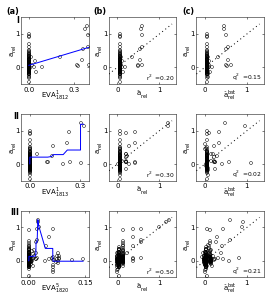

In [17]:
strat_thres = 2
toplot = {'linear': (LinearRegression, 'eva_all', 'pureband1_1812'), 
          'monoincrease':(extIsotonicRegression, 'eva_all', 'pureband1_1813'), 
          'pyramid':(PyramidRegression, 'eva_all', 'pureband5_1820')}

fig_dim = (7.48/2, 4.25)

fig = plt.figure(figsize=fig_dim)

gs = matplotlib.gridspec.GridSpec(5, 3, left=0.08, right=0.98, top=0.93, bottom=0.08, 
                                  hspace=0., wspace=0.3, height_ratios=[4, 1.8, 4, 1.8, 4])
left1 = gs[0,1].get_position(fig).corners()[1,0]
left2 = gs[0,2].get_position(fig).corners()[1,0]
fig.text(0.07, 0.95, '(a)', ha='right', va='center', fontsize=8, fontweight='bold')
fig.text(left1-0.01, 0.95, '(b)', ha='right', va='center', fontsize=8, fontweight='bold')
fig.text(left2-0.01, 0.95, '(c)', ha='right', va='center', fontsize=8, fontweight='bold')

top1 = gs[2,0].get_position(fig).corners()[1,1]+0.01
top2 = gs[4,0].get_position(fig).corners()[1,1]+0.01

fig.text(0.07, 0.92, 'I', ha='right', va='center', fontsize=8, fontweight='bold')
fig.text(0.07, top1-0.015, 'II', ha='right', va='center', fontsize=8, fontweight='bold')
fig.text(0.07, top2-0.015, 'III', ha='right', va='center', fontsize=8, fontweight='bold')

for k_ix, key in enumerate(['linear', 'monoincrease', 'pyramid']):

    Regressor, fspace, feat = toplot[key]
  
    ind = trainsets[fspace].feat_name.index(feat)
    x = trainsets[fspace].features[:,ind]
    x += np.random.randn(trainsets[fspace].features.shape[0])*1E-5
    y =  trainsets[fspace].targets

    regressor = Regressor()
    xfit = x.reshape((-1,1)) if (key == 'linear') else x 
    regressor.fit(xfit,y)
    yhat = regressor.predict(xfit)
    
    estimator_param ={'regressor': Regressor, 'reg_param':{}, 'n_member':100, 'strat_thres':strat_thres}
    estimator = bp.BootstrapRegressor(**estimator_param) 
    estimator.fit(xfit, y)
    
    # target vs feature
    ax = fig.add_subplot(gs[2*k_ix,0])
    ax.plot(x, y, 'o', mfc='none', mec='k', ms=3)
    order = np.argsort(x)
    ax.plot(x[order], yhat[order], 'b')
    ax.set_yticks([0,1])
    #ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=3))
    if k_ix <2:
        ax.set_xticks([0, 0.3])
    else:
        ax.set_xticks([0, 0.15])
    ax.set_ylabel('$a_{rel}$', labelpad=-3)
    xlabel = feat.split('_')
    xlabel[0] = xlabel[0][-1]
    ax.set_xlabel('$EVA^{%s}_{%s}$'%tuple(xlabel), labelpad=-4)
    
    # target vs. target fit 
    ax = fig.add_subplot(gs[2*k_ix,1])
    ax.plot(yhat, y,  'o', mec='k', mfc='none', ms=3)
    ax.plot([-0.2, 1.3], [-0.2, 1.3], 'k:')
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xlabel('$\hat{a}_{rel}$', labelpad=-4)
    ax.set_ylabel('$a_{rel}$', labelpad=-2)
    r2loc = r2_score(np.array(y)[~np.isnan(yhat)], np.array(yhat)[~np.isnan(yhat)])
    ax.text(0.97, 0.02, '$r^2=%.2f$'%r2loc, size=6, transform=ax.transAxes, horizontalalignment='right',
            verticalalignment='bottom')
    
    # target vs bootstrap fit
    ax = fig.add_subplot(gs[2*k_ix,2])
    ax.plot(estimator.oob_prediction, estimator._train_targets.values(), 'o', mec='k', mfc='none', ms=3)
    
    yhat, y = estimator._oob_prediction_single()
    q2 = r2_score(np.array(y)[~np.isnan(yhat)], np.array(yhat)[~np.isnan(yhat)])
    ax.text(0.97, 0.02, '$q^2=%.2f$'%q2, size=6, transform=ax.transAxes, horizontalalignment='right',
            verticalalignment='bottom')
    
    ax.plot([-0.2,1.3], [-0.2,1.3], 'k:')
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xlabel('$\hat{a}_{rel}^{bst}$', labelpad=-4)
    ax.set_ylabel('$a_{rel}$', labelpad=-2)
    

fig.savefig(os.path.join(savepath, 'Fig_univar_model_perf.png'), dpi=300)

#### Multidimensional model 

In [18]:
def plot_multidim_model(fig, gs):
    model, traindata = models_mor182['edragon-eva5']
    order = np.argsort(traindata.targets)


    # Dataspace
    gs_inner = matplotlib.gridspec.GridSpecFromSubplotSpec(1,2,gs[0,0], wspace=0, width_ratios=[9,1])
    ax = fig.add_subplot(gs_inner[0])
    mds = MDS(random_state=4)
    X = mds.fit_transform(traindata.features)

    ax.scatter(*X[order].T, edgecolor='none', s=3, 
               linewidth=0.5, facecolor='k', alpha=0.2)
    ax.scatter(*X[order].T, edgecolor=[plt.cm.YlGn(i) for i in traindata.targets[order]], s=3, 
               linewidth=0.5, facecolor='none', alpha=0.8)        
    ax.set_xticks([-50,0,50])
    ax.set_yticks([-50,0])
    ax.set_ylim([-60, 55])
    ax.set_xlim([-60, 65])
    ax.set_xlabel('MDS1', labelpad=0.1)
    ax.set_ylabel('MDS2', labelpad=-7)
    ax.set_title('$eDR-EVA_5$', size=global_fs, y=0.98)

    ax = fig.add_subplot(gs_inner[1])
    cmap = plt.cm.YlGn
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
    cbar.set_ticks([0, 1])
    #cbar.set_ticklabels(['0', 'max'])
    cbar.set_label('$a_{rel}$', fontsize=global_fs, labelpad=-4)


    # Model fit 
    ax = fig.add_subplot(gs[0,1])
    y = traindata.targets
    yhat = model.full_regressor.predict(traindata.features)
    ax.plot(yhat, y, 'o', mfc='none', mec='k', ms=3)
    ax.plot([-0.2,1.3], [-0.2,1.3], 'k:')
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xlabel('$\hat{a}_{rel}$', labelpad=-4)
    ax.set_ylabel('$a_{rel}$', labelpad=-2)
    r2loc = r2_score(np.array(y)[~np.isnan(yhat)], np.array(yhat)[~np.isnan(yhat)])
    ax.text(0.97, 0.02, '$r^2=%.2f$'%r2loc, size=6, transform=ax.transAxes, horizontalalignment='right',
                verticalalignment='bottom')
    # Bootstrap estimation
    ax = fig.add_subplot(gs[0, 2])
    #std =  [np.std(model._pred_dict[mol]) for mol in model._train_targets.keys()]
    ax.plot(model.oob_prediction, model._train_targets.values(),  'o',
                mfc='none', mec='k', ms=3)
    ax.text(0.97, 0.02, '$q^2=%.2f$'%model.oob_score_single, size=6, transform=ax.transAxes, horizontalalignment='right',
                verticalalignment='bottom')

    '''
    ax.errorbar(model.oob_prediction,model._train_targets.values(),  xerr=std, 
                fmt=None, ecolor='k', linewidth=0.5, capsize=1, alpha=0.5)
    '''
    ax.plot([-0.2,1.3], [-0.2,1.3], 'k:')
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xlabel('$\hat{a}_{rel}^{bst}$', labelpad=-4)
    ax.set_ylabel('$a_{rel}$', labelpad=-2)
    
    left1 = gs[0,1].get_position(fig).corners()[1,0]
    left2 = gs[0,2].get_position(fig).corners()[1,0]
    top = gs[0,0].get_position(fig).corners()[1,1]+0.03
    fig.text(0.08, top, '(a)', ha='right', va='center', fontsize=8, fontweight='bold')
    fig.text(left1, top, '(b)', ha='right', va='center', fontsize=8, fontweight='bold')
    fig.text(left2, top, '(c)', ha='right', va='center', fontsize=8, fontweight='bold')


#### Plot model performance of feature spaces

In [19]:
toplot1 = models_mor182.keys()
toplot2 = ['edragon-eva1', 'edragon-eva5', 'edragon-eva10', 'edragon-eva20', 'edragon-eva50', 'edragon-eva100']
_ = [toplot1.remove(i) for i in toplot2]


In [26]:
def plot_featurespace_perf(fig, gs_full):
    gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_full[1,:], 
                                                     wspace=0.2, width_ratios=[len(toplot1)+1, len(toplot2)+1]) 
    left1 = gs[1].get_position(fig).corners()[1,0]
    fig.text(0.07, 0.51, '(d)', ha='right', va='center', fontsize=8, fontweight='bold')
    fig.text(left1-0.01, 0.51, '(e)', ha='right', va='center', fontsize=8, fontweight='bold')

    for ix, toplot in  enumerate([toplot1, toplot2]):
        performance = np.array([models_mor182[k][0].oob_score_single for k in toplot])
        order = np.argsort(performance)

        ax = fig.add_subplot(gs[ix])
        x = np.arange(performance.size)
        ax.bar(x, np.sort(performance))
        ax.set_xticks(x+0.5)
        ax.set_xticklabels([alias[toplot[i]] for i in order], rotation='90', ha='center', size=6)
        ax.set_ylabel('q2', labelpad=-0.4)
        ax.set_ylim([-0.1, 0.45])
        ax.set_yticks(np.arange(0,0.5,0.1))
        ax.set_yticklabels(['0','','.2','','.4'])
        ax.set_xlim((-0.5, len(toplot)+0.5))
        ax.yaxis.grid(True)


### Make figure

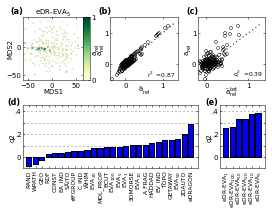

In [27]:
fig_dim = (7.48/2, 3)

fig = plt.figure(figsize=fig_dim)
gs = matplotlib.gridspec.GridSpec(2, 3, left=0.08, right=0.98, top=0.9, bottom=0.2, 
                                  hspace=0.4, wspace=0.3, height_ratios=[4,4])
plot_multidim_model(fig, gs)
plot_featurespace_perf(fig, gs)

fig.savefig(os.path.join(savepath, 'Fig_multivar_model_perf.png'), dpi=300)